In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

In [4]:
sns.set(palette='Set2')

Linear regression assumptions
- linearity with feature and target
- multivariate normality - residual of model should be normally distributed
- homoscedasticity, consistent distribution of error terms
- low multicollinearity

In [5]:
X = pd.read_csv('../../../Downloads/train_features_2013-03-07.csv')

In [6]:
y = pd.read_csv('../../../Downloads/train_salaries_2013-03-07.csv')

In [7]:
X.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


#### Cleaning data

In [8]:
X.isnull().sum() # no nan

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [9]:
# min value
y['salary'].describe()

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

In [10]:
# drop values where salary = 0
drop_row = y.where(y['salary']==0).dropna().index.values 

X.iloc[drop_row, :]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


In [11]:
y.where(y['salary']==0).dropna().index

Int64Index([30559, 495984, 652076, 816129, 828156], dtype='int64')

In [12]:
X.drop(drop_row, 0, inplace=True)
y.drop(drop_row, 0, inplace=True)

### EDA

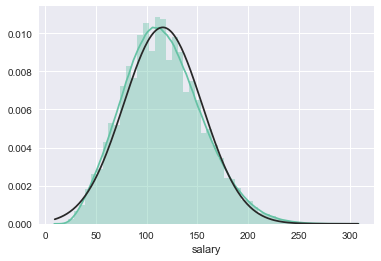

Skewness: 0.346527 
Kurtosis: -0.025751


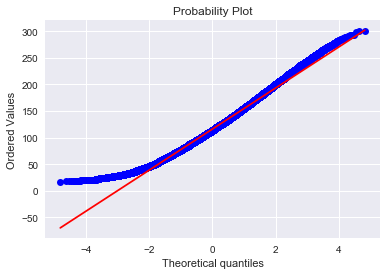

In [13]:
sns.distplot(y['salary'], fit=stats.norm)
plt.show()
print('Skewness: %f' %y['salary'].skew(), '\nKurtosis: %f' %y['salary'].kurt())

stats.probplot(y['salary'], plot=plt)
plt.show()

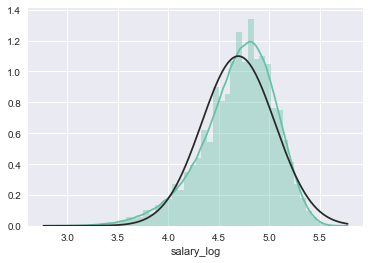

Skewness: -0.664774 
Kurtosis: 0.592215


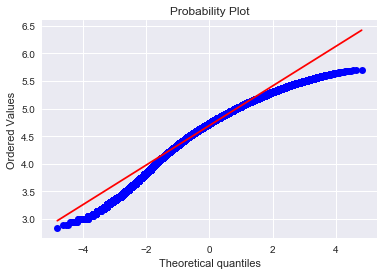

In [14]:
# log transformation
y['salary_log'] = np.log(y['salary'])

sns.distplot(y['salary_log'], fit=stats.norm)
plt.show()
print('Skewness: %f' %y['salary_log'].skew(), '\nKurtosis: %f' %y['salary_log'].kurt())

stats.probplot(y['salary_log'], plot=plt)
plt.show()

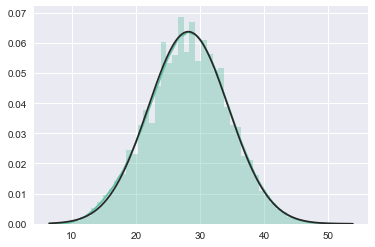

Skewness: -0.015499
Kurtosis: -0.175566


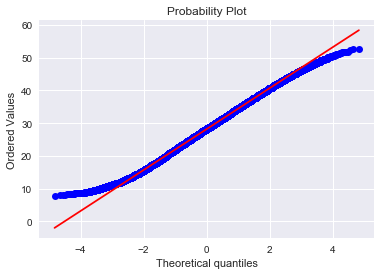

In [15]:
# boxcox transformation
salary_box, salbox = pd.Series(stats.boxcox(y['salary']))

sns.distplot(salary_box, fit=stats.norm)
plt.show()
print('Skewness: %f' '\nKurtosis: %f' %( stats.skew(salary_box),stats.kurtosis(salary_box)))

stats.probplot(salary_box, plot=plt)
plt.show()

In [16]:
df = X.merge(y, on='jobId')
df.shape

(999995, 10)

In [17]:
X0 = df.copy()

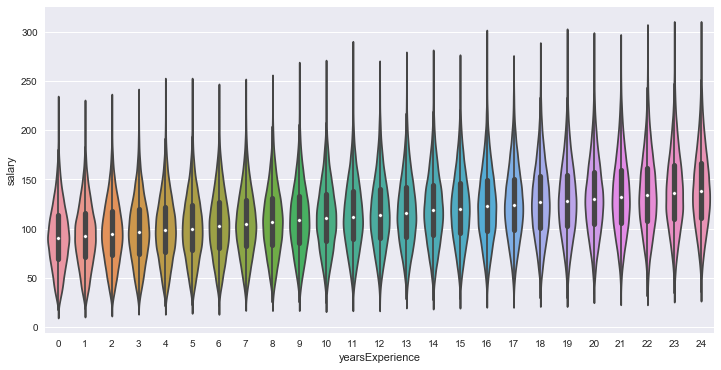

In [18]:
f, ax = plt.subplots(figsize=(12,6))
fig = sns.violinplot(x=X['yearsExperience'], y=y['salary'])

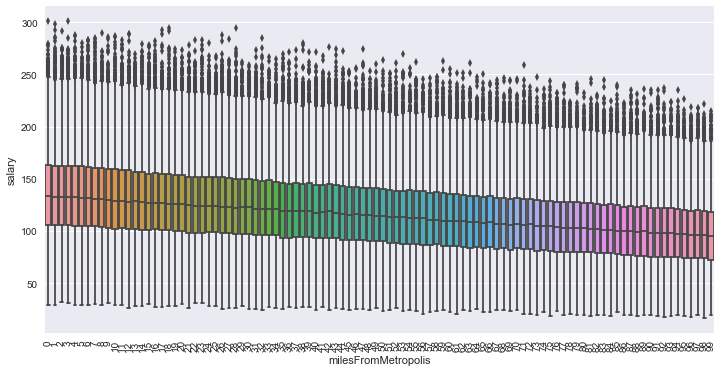

In [19]:
f, ax = plt.subplots(figsize=(12,6))
fig = sns.boxplot(x=X['milesFromMetropolis'], y=y['salary'])
plt.xticks(rotation=90)
plt.show()

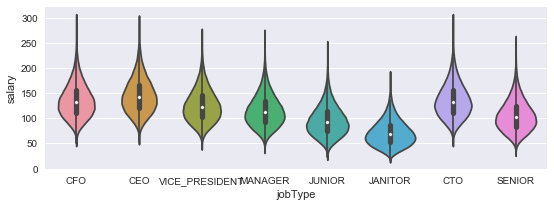

In [20]:
f, ax = plt.subplots(figsize=(9,3))
fig = sns.violinplot(x=X['jobType'], y=y['salary'])

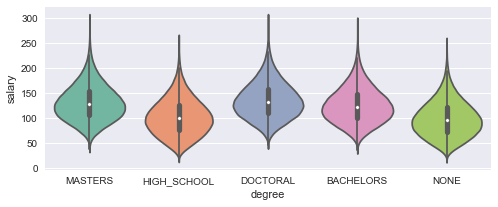

In [21]:
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.violinplot(x=X['degree'], y=y['salary'])

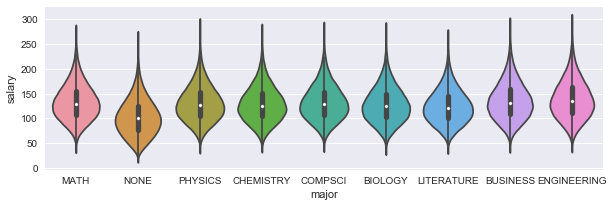

In [22]:
f, ax = plt.subplots(figsize=(10, 3))
fig = sns.violinplot(x=X['major'], y=y['salary'])

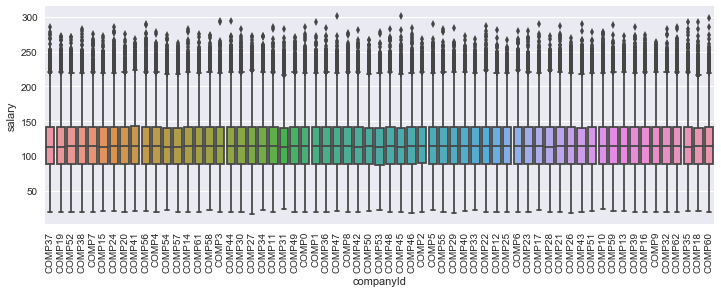

In [23]:
f, ax = plt.subplots(figsize=(12, 4))
fig = sns.boxplot(x=X['companyId'], y=y['salary'])
plt.xticks(rotation=90)
plt.show()

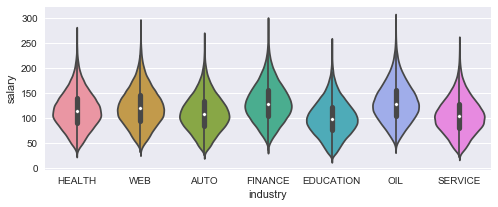

In [24]:
f, ax = plt.subplots(figsize=(8, 3))
fig = sns.violinplot(x=X['industry'], y=y['salary'])

In [25]:
# sorted list of the different categories in each feature

jobType_sorted = df.groupby('jobType')['salary'].mean().sort_values().index.values
degree_sorted = df.groupby('degree')['salary'].mean().sort_values().index.values
major_sorted = df.groupby('major')['salary'].mean().sort_values().index.values
ind_sorted = df.groupby('industry')['salary'].mean().sort_values().index.values

In [26]:
# creating sorted mapping for categorical features

le_job = LabelEncoder()
le_company = LabelEncoder()

data = pd.DataFrame()

data['job_type'] = df['jobType'].map(dict(zip(jobType_sorted, range(len(jobType_sorted)))))
data['degree'] = df['degree'].map(dict(zip(degree_sorted, range(len(degree_sorted)))))
data['major'] = df['major'].map(dict(zip(major_sorted, range(len(major_sorted)))))
data['industry'] = df['industry'].map(dict(zip(ind_sorted, range(len(ind_sorted)))))

data['city_dist'] = df['milesFromMetropolis'].copy()
data['yrs_exp'] = df['yearsExperience'].copy()

data['jobId'] = df['jobId'].copy() 
# data['company_id'] = le_company.fit_transform(X.companyId)

df1 = data.merge(y, on='jobId')

- **Check feature correlation with 'salary'**

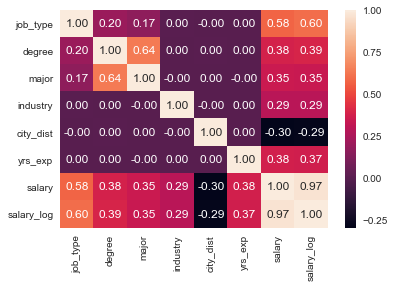

In [27]:
sns.heatmap(df1.corr(), annot=True, fmt='.2f')

- Correlations are not too strong
- create feature-set with average 'salary' for features

In [28]:
df2 = df.copy()

In [29]:
# average 'salary' for values in feature
feat_avg = ['jobType', 'degree', 'major', 'industry']

for feat in feat_avg:
    df_temp = df.groupby(feat)['salary'].mean().reset_index() # table of avg salary for values in feat
    col_name = 'avg_' + feat # new col name
    df_temp.rename(columns={'salary': col_name}, inplace=True)
   
    df2 = df2.merge(df_temp, on=feat)

In [30]:
# avg 'salary' for every feature-pairing
feat2 = feat_avg.copy()

for feat1 in feat_avg:
    feat2.remove(feat1)
    for feat0 in feat2:
        df_temp = df.groupby([feat1, feat0])['salary'].mean().reset_index()
        col_name = 'avg_' + feat1 + '_' + feat0
        df_temp.rename(columns={'salary': col_name}, inplace=True)
        
        df2 = df2.merge(df_temp, on=[feat1, feat0])
    
# rearranging 'salary' last
col_order = df2.columns.tolist()
col_order.append(col_order.pop(col_order.index('salary')))
df2 = df2[col_order]

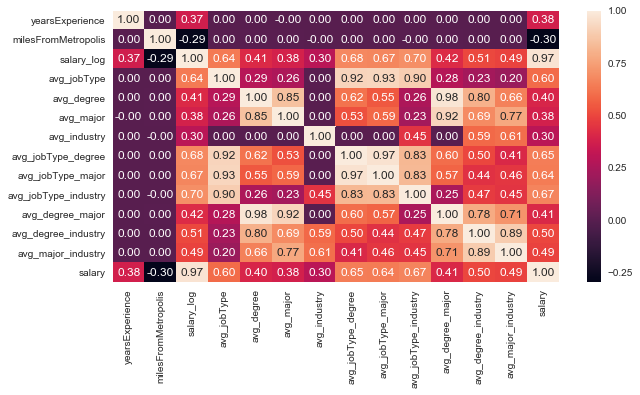

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df2.drop(['jobId', 'companyId'],1).corr(), annot=True, fmt='.2f')

- categorical features show stronger correlation with 'salary' avg
- feature-pairing show stronger correlation than individual correlations

In [32]:
# combine 'yearsExperience' with categorical features
for feat in feat_avg:
    df_temp = df.groupby(['yearsExperience',feat])['salary'].mean().reset_index()
    col_name = 'avg_years_' + feat
    df_temp.rename(columns={'salary': col_name}, inplace=True)
    
    df2 = df2.merge(df_temp, on=['yearsExperience', feat])

In [33]:
# have a 'degree', 'major', 'industry' feature-grouping
DF_TEMP = df2.groupby(['degree', 'major', 'industry'])['salary'].mean().reset_index()
COL_NAME = 'deg_maj_ind'
DF_TEMP.rename(columns={'salary': COL_NAME}, inplace=True)

df2 = df2.merge(DF_TEMP, on=['degree', 'major', 'industry'])

In [34]:
# 'yearsExperience' + 'jobType' + ['degree', 'major', 'industry'] 
for feat in feat_avg[1:]:
    DF_TEMP = df2.groupby(['yearsExperience', 'jobType', feat])['salary'].mean().reset_index()
    COL_NAME = 'avg_years_type_'+ feat
    DF_TEMP.rename(columns={'salary':COL_NAME}, inplace=True)

    df2 = df2.merge(DF_TEMP, on=['yearsExperience', 'jobType', feat])

In [35]:
# 'combine 'yearsExperience' with the 4 categorical features
DF_TEMP = df2.groupby(['yearsExperience', 'jobType', 'degree', 'major', 'industry'])['salary'].mean().reset_index()
COL_NAME = 'avgYrJobDegMajInd'
DF_TEMP.rename(columns={'salary':COL_NAME}, inplace=True)

df2 = df2.merge(DF_TEMP, on=['yearsExperience', 'jobType', 'degree', 'major', 'industry'])

In [36]:
for feat in feat_avg:
    df_temp = df2.groupby(['companyId', feat])['salary'].mean().reset_index()
    name = 'company_' + feat
    df_temp.rename(columns={'salary':name}, inplace=True)
    
    df2 = df2.merge(df_temp, on=['companyId', feat])

In [37]:
# reordering list
col_order4 = df2.columns.tolist() 
# index 'salary, pop that index, append that index back (appends to end)
col_order4.append(col_order4.pop(col_order4.index('salary_log')))
col_order4.append(col_order4.pop(col_order4.index('salary')))
df2 = df2[col_order4]

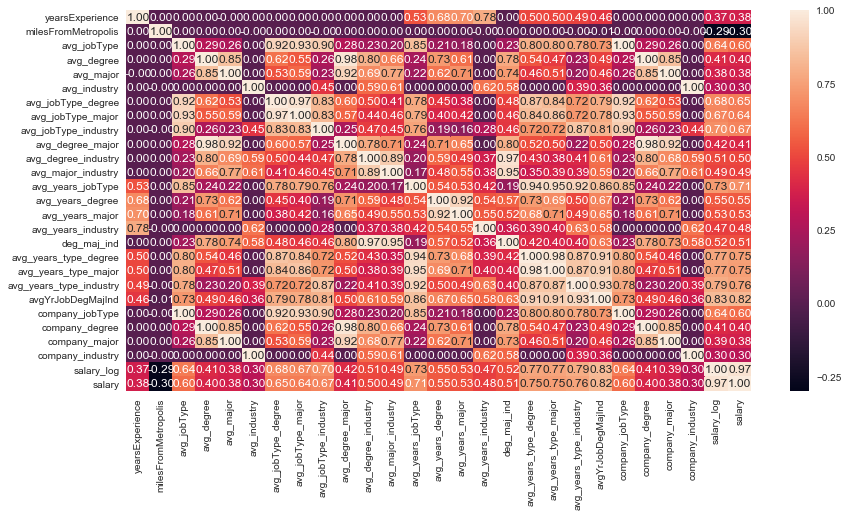

In [38]:
fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(df2.corr(), annot=True, fmt='.2f')

- 'salary_log' has slightly stronger corr with features than 'salary

In [39]:
df2['log_grp'] = np.log(df2['avgYrJobDegMajInd'])

In [40]:
df2['box_grp'], power0 = stats.boxcox(df2['avgYrJobDegMajInd'])
df2['salary_box'] = stats.boxcox(df2['salary'])[0]

grp_scaled = MinMaxScaler().fit_transform(df2.box_grp.values.reshape(-1,1))
sal_scaled = MinMaxScaler().fit_transform(df2.salary_box.values.reshape(-1,1))

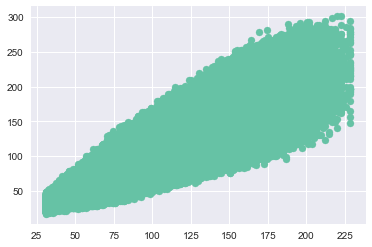

In [41]:
plt.scatter(df2['avgYrJobDegMajInd'], df2['salary'])

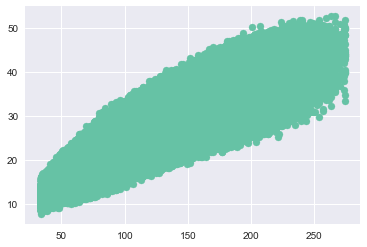

In [42]:
plt.scatter(df2['box_grp'], df2['salary_box'])

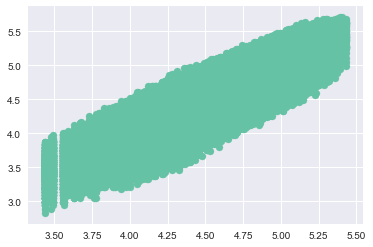

In [43]:
plt.scatter(df2['log_grp'], df2['salary_log'])

In [44]:
df_log = pd.DataFrame()

In [45]:
need_log = ['avg_jobType', 'avg_degree',
       'avg_major', 'avg_industry', 'avg_jobType_degree', 'avg_jobType_major',
       'avg_jobType_industry', 'avg_degree_major', 'avg_degree_industry',
       'avg_major_industry', 'avg_years_jobType', 'avg_years_degree',
       'avg_years_major', 'avg_years_industry', 'deg_maj_ind',
       'avg_years_type_degree', 'avg_years_type_major',
       'avg_years_type_industry']

In [46]:
for col in need_log:
    new_col = 'log_' + col[4:]
    df_log[new_col] = np.log(df2[col])

In [47]:
df_log['log_distance'] = np.log1p(df2['milesFromMetropolis'])

df_log['log_grp'] = df2['log_grp'].copy()

In [48]:
comp_log = ['company_jobType', 'company_degree', 'company_major', 'company_industry']

df_llog = df_log.loc[:,:].copy()

for col in comp_log:
    new_col = 'log_' + col[:4] + '_' + col[8:11]
    df_llog[new_col] = np.log(df2[col])

*** 
#### testing on the one feature: log of 'avgYrJobDegMajInd'

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_log, df2['salary_log'], test_size=0.2, random_state=42)

In [50]:
# print ('Validation-split and test-split are same size? -', X_test.size==X_val.size)

In [51]:
lr = LinearRegression()

In [52]:
lr.fit(X_train['log_grp'].values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
lr.score(X_test['log_grp'].values.reshape(-1,1), y_test)

0.7250803736163998

- Score is not that great, checking other metrics

In [54]:
y_test_exp = np.exp(y_test)

y_ = lr.predict(np.exp(X_test['log_grp'].values.reshape(-1,1)))
mae = mean_absolute_error(y_test_exp, y_)
rmse_ = np.sqrt(mean_squared_error(y_test_exp, y_))

ytrain_ = lr.predict(X_train['log_grp'].values.reshape(-1,1))
mae_tr = mean_absolute_error(y_train, ytrain_)
rmse_tr = np.sqrt(mean_squared_error(y_train, ytrain_))

In [55]:
print('Train: mae - %0.4f \t rmse - %0.4f' % (mae_tr, rmse_tr))
print('Test: mae - %0.4f \t rmse - %0.4f' % (mae, rmse_))
print('\Test scores: %0.4f, and training scores: %0.4f are almost equal' %(rmse_, rmse_tr))

Train: mae - 0.1547 	 rmse - 0.1901
Test: mae - 17.5875 	 rmse - 22.0266
\Test scores: 22.0266, and training scores: 0.1901 are almost equal


***

#### testing on entire X feature set

In [56]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3))
    return rmse

In [57]:
def rmse_score(model):
    y_ = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_))
    return rmse

In [58]:
alphas = [10**i for i in range(-3,4)]

In [59]:
ridgecv1 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

In [60]:
ridgecv1.fit(X_train, y_train)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [61]:
ridgecv1.alpha_

10.0

In [62]:
# the increase in score from previous test is due to 'distance'
ridgecv1.score(X_test, y_test)

0.7856029596721325

In [63]:
ridgecv1.alpha_

10.0

In [64]:
rmse_score(ridgecv1)

0.16820850825751307

***

***

In [65]:
ridge = Ridge()

In [66]:

cv_ridge = [cv_rmse(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

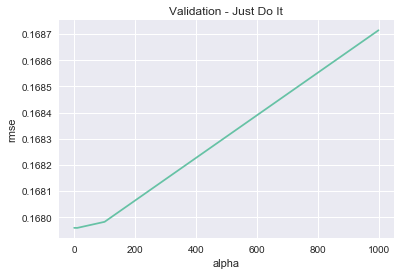

In [67]:
cv_ridge1 = pd.Series(cv_ridge, index=alphas)
cv_ridge1.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

- best score is when alpha is with lowest alpha; 
- aka just an OLS 
    - similar to a one feature linear regression
    - previous X matrix consisted of one crammed-in feature
    

In [68]:
cv_ridge

[0.16795976142318814,
 0.16795975993732584,
 0.1679597453624694,
 0.16795962359027525,
 0.1679594485394713,
 0.16798271162050019,
 0.16871457237229917]

***

***

In [69]:
alphaL = [10**i for i in range(3,-5,-1)]

In [70]:
lassocv = LassoCV(alphas=alphaL, random_state=42).fit(X_train, y_train)

In [71]:
lassocv.score(X_test, y_test)

0.7854119312075989

In [72]:
lassocv.alpha_

0.0001

In [73]:
coef = pd.Series(lassocv.coef_, index=X_train.columns)

In [74]:
# coef.where(coef!=0).dropna().sort_values(key=abs)
# coefficients of lasso 
coef_rein = coef.reindex(coef.abs().sort_values(inplace=False, ascending=False).index)
coef_rein.head(10)

log_grp                    0.902739
log_distance              -0.096057
log_years_type_industry    0.055368
log_maj_ind                0.049565
log_years_type_degree      0.022334
log_jobType_major          0.013271
log_jobType_industry       0.005081
log_years_type_major       0.003345
log_jobType_degree         0.001677
log_degree                 0.000000
dtype: float64

In [75]:
# include these numerical features with ohe (only took coefs > 0.01)
coef_features = coef_rein[:6].index.values
coef_features

array(['log_grp', 'log_distance', 'log_years_type_industry',
       'log_maj_ind', 'log_years_type_degree', 'log_jobType_major'],
      dtype=object)

***
- First, run tests with OHE
- then combine ohe with numericals

## 2 OHE
- LabelEncoder()
- manual map
    - test all the different values for each of the categorical
    - group if hypothesis cannot be rejected

In [76]:
# will assume for time being, but seems to check out
# features that are encoded are not separately added as a column 
ohe4 = OneHotEncoder(n_values='auto')
trunc_svd4 = TruncatedSVD(random_state=42, n_components=4)

In [77]:
df4 = df1[['job_type', 'degree', 'major', 'industry', 'salary_log']]

X4 = df4.iloc[:, :-1]
y4 = df4['salary_log'].ravel()

X_4 = ohe4.fit_transform(X4)

In [78]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, y4, test_size=0.2, random_state=42)

- just ohe on categories

In [79]:
lr4 = LinearRegression()

In [80]:
lr4.fit(X_train4, y_train4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
lr4.score(X_test4, y_test4)

0.5536483122964739

In [82]:
# not running

# lassocv4 = LassoCV(alphas=alphaL, random_state=42).fit(X_train4, y_train4)

- horrible as is, use dimensionality reduction

In [83]:
# fit on train, apply to both
trunc_svd4.fit(X_train4)
X_train4svd = trunc_svd4.transform(X_train4)
X_test4svd = trunc_svd4.transform(X_test4)

lr_4 = LinearRegression()

In [84]:
lr_4.fit(X_train4svd, y_train4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
lr_4.score(X_test4svd, y_test4)

0.27489300549358786

- using log average salaries of previously extracted "important features" (coef_features)

In [86]:
X5 = df_log[coef_features]
y5 = df2['salary_log']

pca5 = PCA(random_state=42)

In [87]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [88]:
pca5.fit(X_train5)

X_train5pca = pca5.transform(X_train5)
X_test5pca = pca5.transform(X_test5)

In [89]:
pca5.explained_variance_

array([0.85628741, 0.28923584, 0.02444435, 0.01881001, 0.00698126,
       0.00130865])

In [90]:
lr_5 = LinearRegression()

In [91]:
lr_5.fit(X_train5, y_train5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
lr_5.score(X_test5, y_test5)

0.7854293071929461

In [93]:
lr_5.fit(X_train5pca, y_train5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
lr_5.score(X_test5pca, y_test5)

0.7854293071929461

- same(?) or very similar results with the entire numerical-features feature set

In [95]:
r_5 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

In [96]:
r_5.fit(X_train5pca, y_train5)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [97]:
r_5.score(X_test5pca, y_test5)

0.7854293233969931

In [98]:
r_5.alpha_

0.1

In [99]:
y_5pca = r_5.predict(X_test5pca)

In [100]:
print('Test score is very nearly identical with the previous (fuller) featureset, but MAE and MSE are slightly improved ')

print('mae - %0.4f \trmse - %0.4f' % (mean_absolute_error(y_test5, y_5pca), np.sqrt(mean_squared_error(y_test5, y_5pca))))

Test score is very nearly identical with the previous (fuller) featureset, but MAE and MSE are slightly improved 
mae - 0.1394 	rmse - 0.1683


In [101]:
np.sqrt(mean_squared_error(y_test5, y_5pca))

0.1682766089822116

In [102]:
df11 = df2.merge(df1, on='jobId')
df_1 = df11[['job_type', 'degree_y', 'major_y', 'industry_y']]

In [103]:
df_all = df_1.merge(df_log, right_index=True, left_index=True)

In [104]:
svd6 = TruncatedSVD(random_state=42, n_components=35)
ohe6 = OneHotEncoder(n_values='auto', categorical_features=[0,1,2,3])

In [105]:
df_a_enc = ohe6.fit_transform(df_all)

In [106]:
df_a_enc

<999995x49 sparse matrix of type '<class 'numpy.float64'>'
	with 23989757 stored elements in COOrdinate format>

In [107]:
df_all.shape # how did features go from 24 to 72? 
 ## (sum of all feature categories = 29)

(999995, 24)

In [108]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(df_a_enc, df2['salary_log'], test_size=0.2, random_state=42)

In [109]:
svd6.fit(X_train6)

TruncatedSVD(algorithm='randomized', n_components=35, n_iter=5,
       random_state=42, tol=0.0)

In [110]:
X_train6svd = svd6.transform(X_train6)
X_test6svd = svd6.transform(X_test6)

In [111]:
r_6 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

In [112]:
r_6.fit(X_train6svd, y_train6)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [113]:
r_6.alpha_ # no regularization?

1.0

In [114]:
r_6.score(X_test6svd, y_test6)

0.7856082817843847

In [115]:
y6_ = r_6.predict(X_test6svd)

In [116]:
mean_absolute_error(np.exp(y_test6), np.exp(y6_))

15.899978667856011

In [117]:
np.sqrt(mean_squared_error(np.exp(y_test6), np.exp(y6_)))

19.876963519941985

- last model, no ohe

In [118]:
df1_log = np.log1p(df_1)

df_all_log = df1_log.merge(df_log, right_index=True, left_index=True)

In [119]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(df_all_log, df2['salary_log'], test_size=0.2, random_state=42)

In [120]:
pca7 = PCA(random_state=42)

pca7.fit(X_train7)

X_train7pca = pca7.transform(X_train7)
X_test7pca = pca7.transform(X_test7)

In [121]:
r_7 = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
l_7 = LassoCV(alphas=alphaL, random_state=42)

In [122]:
l_7.fit(X_train7pca, y_train7)

LassoCV(alphas=[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], copy_X=True,
    cv=None, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=42, selection='cyclic', tol=0.0001, verbose=False)

In [123]:
l_7.score(X_test7pca, y_test7)

0.7852789245678878

In [124]:
r_7.fit(X_train7pca, y_train7)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [125]:
r_7.score(X_test7pca, y_test7)

0.7856058540810198

In [126]:
y7pca_ = r_7.predict(X_test7pca)

In [127]:
np.sqrt(mean_squared_error(y_test7, y7pca_))

0.16820737282708997

In [128]:
from scipy import special

In [129]:
df_logexp = np.exp(df_llog)

X_trainl, X_testl, y_trainl, y_testl = train_test_split(df_logexp, df2['salary'], test_size=0.2, random_state=42)

In [130]:
r_last = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

In [131]:
df_Xl = pd.DataFrame(X_trainl)
df_Xtrain = pd.DataFrame()
boxpower = []

for col in df_Xl:
    df_Xtrain[col], power = stats.boxcox(df_Xl[col])
    boxpower.append(power)
    
y_boxtrain, ypower = stats.boxcox(y_trainl)

In [139]:
df_Xtrain

,log_jobType,log_degree,log_major,log_industry,log_jobType_degree,log_jobType_major,log_jobType_industry,log_degree_major,log_degree_industry,log_major_industry,...,log_maj_ind,log_years_type_degree,log_years_type_major,log_years_type_industry,log_distance,log_grp,log_comp_job,log_comp_deg,log_comp_maj,log_comp_ind
0,46964.836027,16.304943,0.443943,18.851509,2739.123363,2337.302215,1680.235918,2.089054,26.659952,3.352487,...,6.805592,375.100205,341.134396,292.691392,24.874998,106.489899,44529.105589,16.224923,0.439644,19.009995
1,56590.288768,13.942735,0.443938,22.002886,2177.083352,2144.116583,2910.786591,2.045629,25.847657,3.376732,...,6.737480,372.998636,377.817565,569.047125,19.293039,151.640349,55283.494994,13.921978,0.439639,22.485350
2,56590.288768,16.304943,0.443942,19.384079,3080.517581,2520.231526,2111.466744,2.084524,27.318676,3.355491,...,6.820794,422.446786,372.977342,353.111066,18.598464,135.577380,56369.132495,16.253915,0.439644,19.629586
3,38443.301148,14.201091,0.443938,21.128189,1733.527588,1597.066134,2020.076780,2.051127,24.876891,3.333334,...,6.618902,378.931720,364.372295,502.911181,34.574346,143.192955,36793.926490,14.212204,0.439639,21.573428
4,30985.881938,16.304943,0.443943,19.384079,2107.632347,1785.307197,1315.746296,2.089054,27.318676,3.372977,...,6.881365,385.409536,353.446934,319.567373,14.586424,127.850183,30946.481190,16.326685,0.439644,19.801615
5,11864.973251,14.201091,0.443938,22.002886,870.213443,813.770718,1112.699805,2.051127,26.356070,3.376732,...,6.798320,289.519942,278.475831,387.983277,12.223507,128.226078,11908.432117,14.209905,0.439639,22.355707
6,38443.301148,13.942735,0.443938,18.851509,1593.375386,1597.066134,1436.753930,2.045629,21.187596,3.230015,...,6.135822,285.667908,293.785323,308.239528,24.874998,89.294499,37756.670008,13.986327,0.439639,19.187436
7,56590.288768,14.201091,0.443938,20.543209,2328.051647,2144.116583,2425.642608,2.051127,24.213342,3.309976,...,6.535945,349.164169,335.814556,444.775413,26.119226,127.096187,54237.478502,14.165691,0.439639,20.903408
8,67017.188102,13.942735,0.443938,21.128189,2483.321284,2435.012686,2935.715090,2.045629,24.393526,3.333334,...,6.558629,426.499036,430.793763,586.260003,26.733047,156.311034,65726.904919,13.912141,0.439639,21.607570
9,56612.951344,14.201091,0.443938,22.022354,2331.788180,2146.628976,2916.015410,2.051127,26.373818,3.377083,...,6.800429,440.529733,424.311850,623.863018,0.000000,175.882156,54294.909596,14.187393,0.439639,22.487183


In [132]:
r_last.fit(df_Xtrain, y_boxtrain)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=None,
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [140]:
df_Xtestl = pd.DataFrame(X_testl)
df_Xtest = pd.DataFrame()

for ind, col in enumerate(df_Xtestl):
    df_Xtest[col] = stats.boxcox(df_Xtestl[col], alpha=boxpower[ind])[0]

0 log_jobType
1 log_degree
2 log_major
3 log_industry
4 log_jobType_degree
5 log_jobType_major
6 log_jobType_industry
7 log_degree_major
8 log_degree_industry
9 log_major_industry
10 log_years_jobType
11 log_years_degree
12 log_years_major
13 log_years_industry
14 log_maj_ind
15 log_years_type_degree
16 log_years_type_major
17 log_years_type_industry
18 log_distance
19 log_grp
20 log_comp_job
21 log_comp_deg
22 log_comp_maj
23 log_comp_ind


In [134]:
y_boxtest = stats.boxcox(y_testl, alpha=ypower)[0]

In [135]:
r_last.score(df_Xtest, y_boxtest)

-22441965.880620494

In [136]:
df_Xtestl

,log_jobType,log_degree,log_major,log_industry,log_jobType_degree,log_jobType_major,log_jobType_industry,log_degree_major,log_degree_industry,log_major_industry,...,log_maj_ind,log_years_type_degree,log_years_type_major,log_years_type_industry,log_distance,log_grp,log_comp_job,log_comp_deg,log_comp_maj,log_comp_ind
58413,125.368630,130.505647,130.372436,121.645362,133.077062,132.872443,131.446657,130.622320,137.241080,143.713012,...,143.665152,133.008264,131.429487,129.687583,22.0,146.000000,125.705572,131.523775,131.363445,121.548936
902613,115.368518,125.454663,138.441342,99.448386,118.173795,131.577487,98.944513,133.522468,107.975063,114.957983,...,109.165890,125.542389,136.946108,105.118156,69.0,114.000000,116.123239,125.353195,136.481560,100.472441
778821,105.487775,98.176882,102.583864,115.735540,90.628738,95.082839,105.141989,98.176882,97.286797,101.946463,...,97.286797,111.901718,116.562158,126.351245,14.0,110.915152,106.124747,97.460512,102.374795,116.305408
187592,95.333087,135.490979,133.322042,104.446820,108.356035,106.217693,83.558421,138.394916,123.018179,120.177569,...,125.272154,88.353695,86.083086,63.942817,54.0,72.960000,95.123562,135.929718,134.403050,104.500436
574436,115.368518,130.505647,130.372436,121.645362,123.389176,122.699763,120.930051,130.622320,137.241080,143.713012,...,143.665152,117.580707,116.767296,114.735632,50.0,126.650000,116.731707,129.919428,130.869239,121.620528
13143,115.368518,125.454663,130.372436,99.448386,118.173795,122.699763,98.944513,125.209302,107.975063,113.092736,...,108.394294,117.204717,120.849850,96.794466,8.0,106.157895,115.466699,124.179562,129.265351,98.742398
840892,135.458547,125.454663,132.075605,130.953863,138.508706,144.469856,150.337443,126.965316,140.997392,146.695480,...,141.201509,135.628125,139.558480,146.517699,85.0,154.636364,135.898734,126.255806,131.162248,130.951979
433047,135.458547,98.176882,102.583864,104.446820,121.135389,125.272393,124.122543,98.176882,87.404719,91.781626,...,87.404719,105.743119,110.301540,109.489971,65.0,95.861111,134.875712,97.653415,102.681618,105.323710
413529,105.487775,101.921085,102.583864,115.735540,95.908637,95.082839,105.141989,101.921085,101.549296,101.946463,...,101.549296,115.301604,113.832171,122.890582,14.0,115.789809,106.080392,102.077956,102.436463,114.633290
204133,115.368518,125.454663,127.932664,130.747659,118.173795,120.651605,129.955841,123.204343,140.375583,140.146870,...,135.276766,123.615385,126.691643,134.294925,8.0,138.700000,115.854123,124.859910,127.754310,132.838710


In [137]:
df_Xtest

,log_jobType,log_degree,log_major,log_industry,log_jobType_degree,log_jobType_major,log_jobType_industry,log_degree_major,log_degree_industry,log_major_industry,...,log_maj_ind,log_years_type_degree,log_years_type_major,log_years_type_industry,log_distance,log_grp,log_comp_job,log_comp_deg,log_comp_maj,log_comp_ind
0,47787.365246,17.116176,0.121266,20.590034,2582.134084,2349.107491,2317.086281,0.121266,29.475665,0.118727,...,7.493758,454.129123,426.685311,496.684597,11.499057,172.392054,46826.217692,17.004968,0.121266,21.039892
1,39103.806948,16.782274,0.121266,18.395602,2105.701770,2310.412233,1430.828058,0.121266,25.347996,0.118727,...,6.911519,421.071424,450.057139,374.983939,27.998858,132.968939,38692.200247,16.604130,0.121266,18.894268
2,31507.168820,14.833302,0.121266,20.026514,1334.900587,1331.698404,1586.237908,0.121266,23.728988,0.118727,...,6.674571,362.231635,365.154167,479.664228,7.914575,129.191652,31154.919770,14.636739,0.121266,20.524174
3,24680.854612,17.438715,0.121266,18.909245,1814.288215,1606.882312,1073.980939,0.121266,27.519885,0.118727,...,7.200190,265.851519,246.377622,192.666470,23.237261,83.130226,23941.579206,17.284734,0.121266,19.320095
4,39103.806948,17.116176,0.121266,20.590034,2267.811272,2052.283099,2011.329717,0.121266,29.475665,0.118727,...,7.493758,386.476218,365.988160,421.597135,21.907756,148.503115,39181.878011,16.901787,0.121266,21.046858
5,39103.806948,16.782274,0.121266,18.395602,2105.701770,2052.283099,1430.828058,0.121266,25.347996,0.118727,...,6.896807,384.859756,382.675009,335.778078,4.825776,123.375431,38167.867476,16.526642,0.121266,18.708833
6,57598.919086,16.782274,0.121266,21.450979,2765.756935,2707.298971,2910.081665,0.121266,29.978183,0.118727,...,7.456346,465.866405,461.222650,584.746195,32.768225,183.099330,56490.070022,16.663446,0.121266,21.938372
7,57598.919086,14.833302,0.121266,18.909245,2197.141333,2125.792948,2102.267573,0.121266,22.166241,0.118727,...,6.458043,336.362408,339.912070,396.002918,26.760097,110.825504,55472.164196,14.651367,0.121266,19.406143
8,31507.168820,15.117401,0.121266,20.026514,1471.253306,1331.698404,1586.237908,0.121266,24.382935,0.118727,...,6.762271,376.702267,354.096727,462.168434,7.914575,135.162514,31123.594186,14.982529,0.121266,20.357352
9,39103.806948,16.782274,0.121266,21.432240,2105.701770,1994.520023,2272.666110,0.121266,29.895378,0.118727,...,7.364066,412.634810,406.841933,520.431305,4.825776,163.362690,38476.769815,16.571611,0.121266,22.114838


In [138]:
special.inv_boxcox(X_testl, )

ValueError: invalid number of arguments

In [ ]:
ylast_ = r_last.predict(X_testl)

In [ ]:
mean_absolute_error(y_testl, ylast_)

In [ ]:
np.sqrt(mean_squared_error(y_testl, ylast_))

In [ ]:
100/1000000

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor

#### - might have to pca sparse matrix

In [ ]:
en_cv = ElasticNetCV(alphas=alphas, l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, .99],
                    max_iter=3000)

In [ ]:
en_cv.fit(X_train5, y_train5)

In [ ]:
en_cv.score(X_test5, y_test5)

In [ ]:
en_cv1 = ElasticNetCV(alphas=alphas, l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, .99],
                    max_iter=3000)

In [ ]:
en_cv1.fit(X_train6svd, y_train6)

In [ ]:
en_cv1.score(X_test6svd, y_test6)

In [ ]:
en_cv2 = ElasticNetCV(alphas=alphas, l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, .99],
                    max_iter=3000)

In [ ]:
# en_cv2.fit(X_train6, y_train6)

In [ ]:
# en_cv2.score(X_test6, y_train6)

- The advantages of GBRT are:

Natural handling of data of mixed type (= heterogeneous features)...

In [ ]:
# for max_depth of 3, min_samples_leaf/split should be somewhat high?

gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3
                              ,min_samples_leaf=15, min_samples_split=10, loss='huber')

In [ ]:
X_train5.head()

In [ ]:
# gb.fit(X_train5, y_train5) # long time

In [ ]:
# gb.score(X_test5, y_test5)

In [ ]:
X_train6svd.shape

In [ ]:
gb1 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3
                              ,min_samples_leaf=100, min_samples_split=100)

In [ ]:
# gb1.fit(X_train6, y_train6)

In [ ]:
# gb1.score(X_test6, y_test6)

In [ ]:
# will assume for time being, but seems to check out
# features that are encoded are not separately added as a column 
ohe = OneHotEncoder(n_values='auto', categorical_features=[0,1,2,3])

In [ ]:
# will not include these columns ('salary' will be added back for convenience)
df_pipe1 = df4.drop(['salary', 'company_id', 'job_id'], 1)

In [ ]:
df_pipe1.shape

In [ ]:
df2_cols = ['avg_jobType', 'avg_degree',
       'avg_major', 'avg_industry', 'avg_jobType_degree', 'avg_jobType_major',
       'avg_jobType_industry', 'avg_degree_major', 'avg_degree_industry',
       'avg_major_industry', 'avg_company_jobType', 'avg_company_degree',
       'avg_company_major', 'avg_company_industry', 'avg_years_jobType',
       'avg_years_degree', 'avg_years_major', 'avg_years_industry',
       'deg_maj_ind', 'salary']

In [ ]:
df_pipe1[df2_cols] = df2[df2_cols]

In [ ]:
# scaler
min_max = MinMaxScaler() 

scaled_feats = min_max.fit_transform(df_pipe1[['city_dist', 'yrs_exp']])
scaled_feats2 = min_max.fit_transform(df_pipe1[df2_cols])

In [ ]:
df_pipe1[['city_dist', 'yrs_exp']] = scaled_feats
df_pipe1[df2_cols] = scaled_feats2

In [ ]:
df_pipe1.head()

In [ ]:
X_pipe1 = df_pipe1.drop('salary', 1)
y_pipe1 = df_pipe1.loc[:, 'salary']

In [ ]:
X_ohe = ohe.fit_transform(X_pipe1)

In [ ]:
X_ohe # 25 cols from df_pipe1, minus 4 features being encoded, + 29 distinct values

In [ ]:
stop 

In [ ]:
sns.pairplot(df.drop(['job_id', 'company_id'],1))
plt.show()

In [ ]:
# the useless

In [ ]:
# # average salary for company_id-pair values
# for feat in feat_avg:
#     df_temp = df.groupby(['companyId', feat])['salary'].mean().reset_index()
#     col_name = 'avg_company_' + feat
#     df_temp.rename(columns={'salary': col_name}, inplace=True)
    
#     df2 = df2.merge(df_temp, on=['companyId', feat])

In [ ]:
# # for each categorical feature
# for feat in feat_avg:

#     col_number = len(np.unique(df[feat]))
    
#     grouped = df.groupby(feat)['salary']
    
    
#     # for each category and salaries for that category
#     for name, group in grouped:
#         sns.distplot(group, axlabel=name)
#         plt.title(feat)
#         plt.show()
#         print('Skew: %0.4f' % group.skew())
#         print('Kurtosis: %0.4f' % group.kurt())

In [ ]:
# # for each categorical feature
# for feat in feat_avg:

#     col_number = len(np.unique(df[feat]))
    
#     grouped = df.groupby(feat)['salary']
    
#     fig, axes = plt.subplots(1,col_number, figsize=(15,2))
    
#     # for each category and salaries for that category
#     for (name, group), ax in zip(grouped, axes.flatten()):
#         group.hist(ax=ax, ylabelsize=5, xlabelsize=4, label=name)

In [ ]:
# for feat in feat_avg:
#     print('-----',feat,'-----')
#     categories = list(set(df[feat]))
#     cat0 = df.where(df[feat]==cat).dropna()['salary']
    
#     for cat in categories.copy():
#         cat0 = df.where(df[feat]==cat).dropna()['salary']
#         categories.remove(cat)
#         for cat_1 in categories:
#             cat_temp = df.where(df[feat]==cat_1).dropna()['salary']
#             t_stat, pval = stats.ttest_ind(cat0, cat_temp)
#             print(cat, cat_1, '%0.4f' , '%0.4f' % pval, t_stat )

In [ ]:
df2.groupby('jobType')['salary'].mean().reset_index()

In [ ]:
df2['avg_jobType'] = df2.groupby('jobType')['salary'].mean().reset_index()

jobType_sorted = df.groupby('jobType')['salary'].mean().sort_values().index.values
df2['job_rank'] = df2['jobType'].map(dict(zip(jobType_sorted, range(len(jobType_sorted)))))

In [ ]:
minmax = MinMaxScaler(feature_range=(0,7))
df2['salary_scaled'] = minmax.fit_transform(df2['salary'].values.reshape(-1,1))

In [ ]:
print(np.unique(df2.jobType) ,len(np.unique(df2.jobType)))

In [ ]:
sns.heatmap(df2[['jobType', 'job_rank', 'salary_scaled']].corr())

In [ ]:
sns.heatmap(df2[['jobType', 'avg_jobType', 'salary']].corr())

In [ ]:
df2[['jobType', 'job_rank', 'salary_scaled']].corr()

In [ ]:
df2[['jobType', 'avg_jobType', 'salary']].corr()

In [ ]:
df2[['jobType', 'job_rank', 'salary_scaled']]

In [ ]:
df2[['jobType', 'avg_years_type_degree', 'avg_jobType', 'salary']]

In [ ]:
df2.columns

***